In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

import time

#useful if you run the code on google colab

#from google.colab import drive
#drive.mount('/content/drive') 


In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [4]:
train_images.shape

(60000, 28, 28, 1)

In [0]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image*127.5+127.5, cmap="gray")
        plt.axis("off")

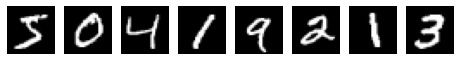

In [6]:
plot_multiple_images(train_images[:8],8)

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 100

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=[codings_size]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [0]:
generator = make_generator_model()
discriminator = make_discriminator_model()
gan = keras.models.Sequential([generator, discriminator])

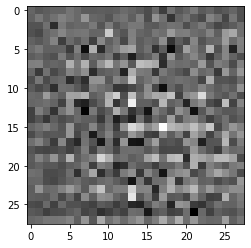

In [11]:
noise = tf.random.normal([1, codings_size])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [0]:
adam_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
discriminator.compile(loss="binary_crossentropy", optimizer=adam_optimizer)
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer=adam_optimizer)

In [0]:
batch_size = 16
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

path_to_folder =""

In [0]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.95]] * batch_size + [[0.05]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[0.05]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 4)  
        plt.savefig(path_to_folder+'Images_MNIST/image_at_epoch_{:04d}.png'.format(epoch))                   
        plt.show()  

In [0]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image*127.5+127.5, cmap="gray")
        plt.axis("off")

## Inversed labels 0->0.95 1->0.05

In [0]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=30)

Epoch 1/30


## Generate a Gif with the results

In [0]:
# Create the frames

anim_file = 'dcgan_mnist.gif'

frames = []
imgs = glob.glob(path_to_folder'/Images_CIFAR10/image*.png')
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 

frames[0].save(anim_file, format='GIF',append_images=frames[1:],save_all=True,duration=200, loop=0)

In [0]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(anim_file)